# Electrocardiogram processing for the recognition of sleep stages
# ecg.csv 250Ηz ecg data for 8 hours of sleep

   seconds    ECG
0    0.000 -0.212
1    0.004 -0.227
2    0.008 -0.227
3    0.012 -0.220
4    0.016 -0.188


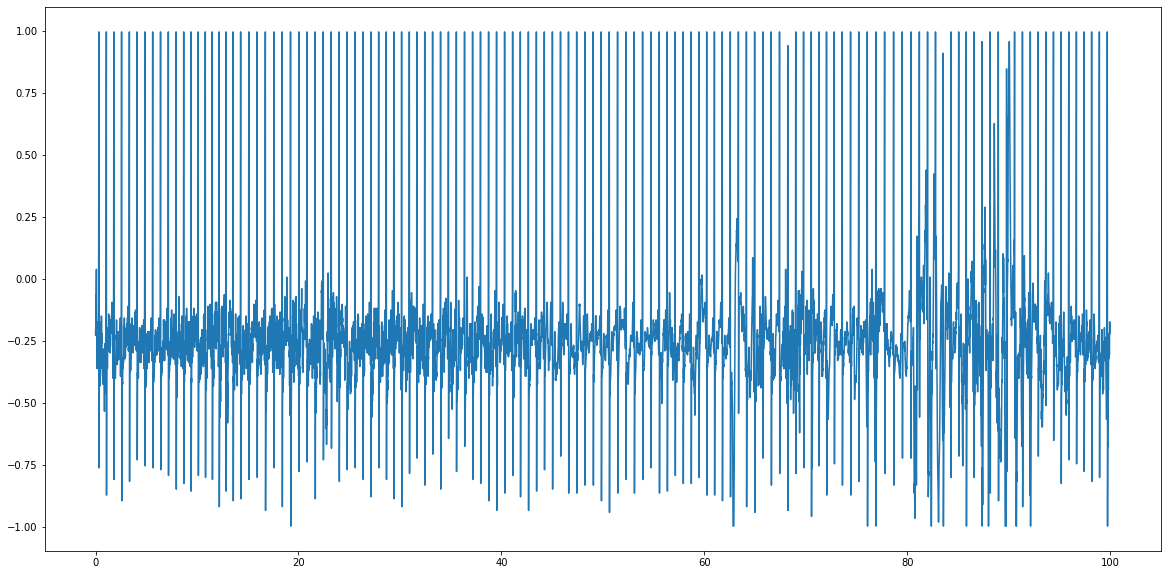

In [2]:
#read ecg.csv and plot the first 100 seconds of the signal
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as stats
import scipy.interpolate as interpolate
import scipy.optimize as optimize
import scipy.integrate as integrate
from scipy import signal

#read the data
data = pd.read_csv('ecg.csv')
print(data.head())
#given that column one is seconds
#column 2 is the ECG signal
#plot the first 100 seconds of the signal
#set size of the plot to be large
plt.figure(figsize=(20, 10))
plt.plot(data['seconds'][0:25000],data['ECG'][0:25000])




In [3]:
#parse sleep.txt that contains the correct answers for the sleep stages every 30 seconds (NREM, REM_WAKE)
#we will load the file to a dataframe

sleep_dataframe = pd.read_csv('sleep.txt',sep='\t')
print(sleep_dataframe.head())
#column 1 is the seconds (every 30 seconds)
#column 2 is the sleep stage (Aux)


   Seconds       Aux
0        0  REM_Wake
1       30  REM_Wake
2       60  REM_Wake
3       90  REM_Wake
4      120  REM_Wake


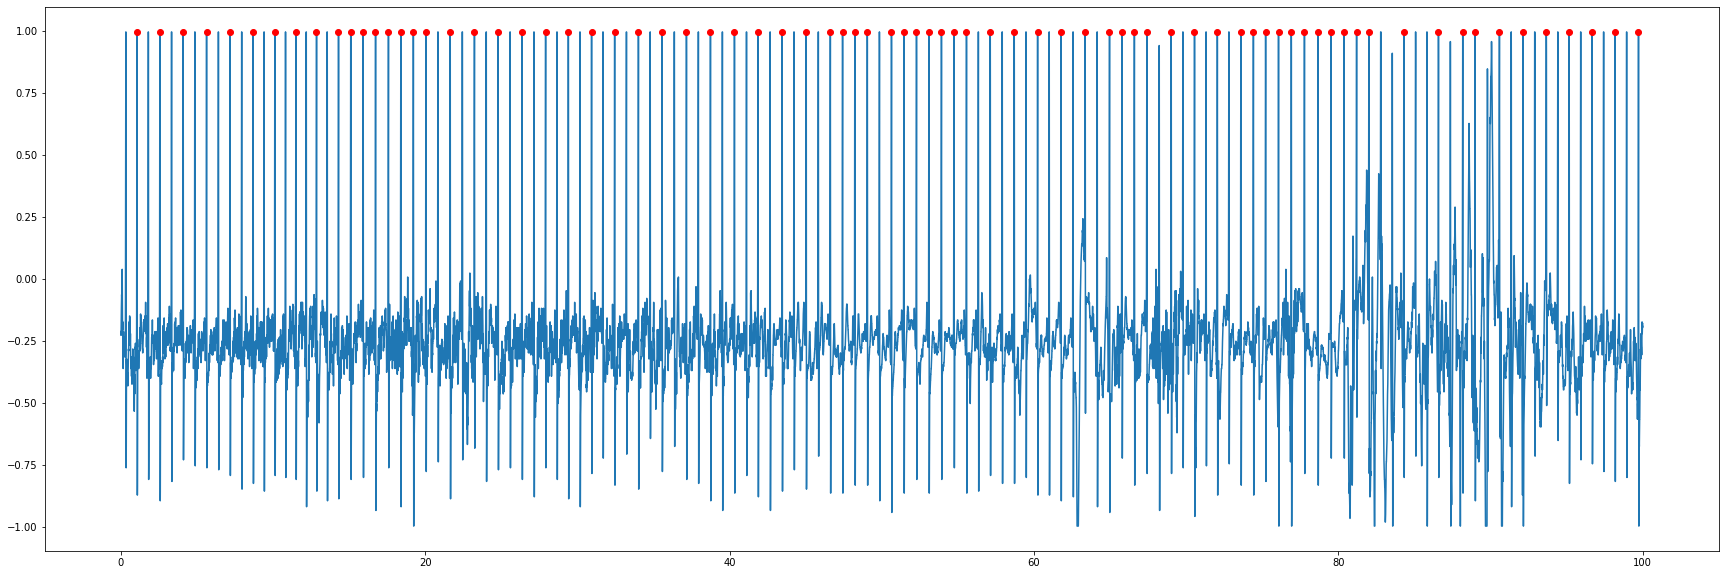

In [5]:
#we will find the rPeaks with a threshold of 0.35mV and we will plot the rPeaks (first 100 seconds) 
r_peaks = signal.find_peaks(data['ECG'][0:25000], height=0.35, distance=200)

#r_peaks 0 contains the indices of the rPeaks and r_peaks 1 contains the values of the rPeaks (heights)

#make plot large
plt.figure(figsize=(30,10))
#we want to plot the indices as red dots on top of the signal (first 100 seconds)
plt.plot(data['seconds'][0:25000],data['ECG'][0:25000])
plt.plot(data['seconds'][r_peaks[0]],data['ECG'][r_peaks[0]],'ro')



### FIND RR INTERVALS (TIME BETWEEN TWO PEAKS) AND THE TIME (IN SECONDS) OF THE FIRST PEAK , STORE IN DATA FRAME

   RR_intervals  timestamps
0           376       1.056
1           381       2.560
2           385       4.084
3           386       5.624
4           380       7.168


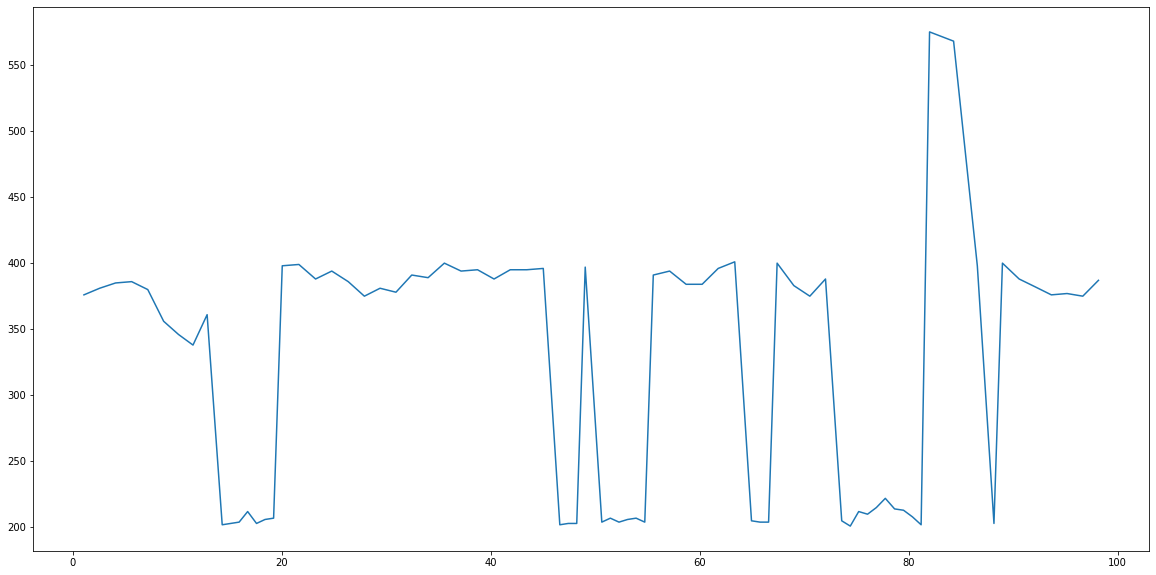

In [4]:
#create dataframe with RR intervals and their timestamps
rr_intervals = pd.DataFrame(columns=['RR_intervals','timestamps'])
#we will use the rPeaks to find the RR intervals
rr_intervals['RR_intervals'] = np.diff(r_peaks[0])
#we will use the rPeaks to find the RR intervals
rr_intervals['timestamps'] = r_peaks[0][:-1]
#format timestamps to be in seconds (given that we are in 250hz)
rr_intervals['timestamps'] = rr_intervals['timestamps']/250
#print the first 5 rows of the dataframe
print(rr_intervals.head())

#plot the rr intervals as a signal
plt.figure(figsize=(20,10))
plt.plot(rr_intervals['timestamps'],rr_intervals['RR_intervals'])

#### Since the RR intervals do not have a stable frequency, we want to transform our signal to 2hz for the total of 32399 seconds.

In [6]:
#since the original rate is 250hz, and we have 8099750 lines , that means 32399 seconds
#our goal is to downsample the data to 2hz meaning we will have 64,798 lines
#we will create a temporary dataframe to store the average ECG signal every 0.5 seconds
temp_dataframe = []
#we will loop the data_copy and find the average ECG signal every 0.5 seconds (125 lines)
for i in range(0, 8099750, 125):
    #we will take the average of the ECG signal every 0.5 seconds
    temp_dataframe.append(np.mean(data['ECG'][i:i+125]))

#now we will create a new dataframe , columns are seconds and ECG
data_transformed = pd.DataFrame(columns=['seconds','ECG'])
#fill up the seconds column, every 0.5 seconds for 32399 seconds
data_transformed['seconds'] = np.arange(0,32399,0.5)
#fill up the ECG column with the values from temp_dataframe
data_transformed['ECG'] = temp_dataframe


   RR_intervals  timestamps
2           939      3524.0
3          7674      3993.5
4         37774      7830.5
5           171     26717.5
6            70     26803.0


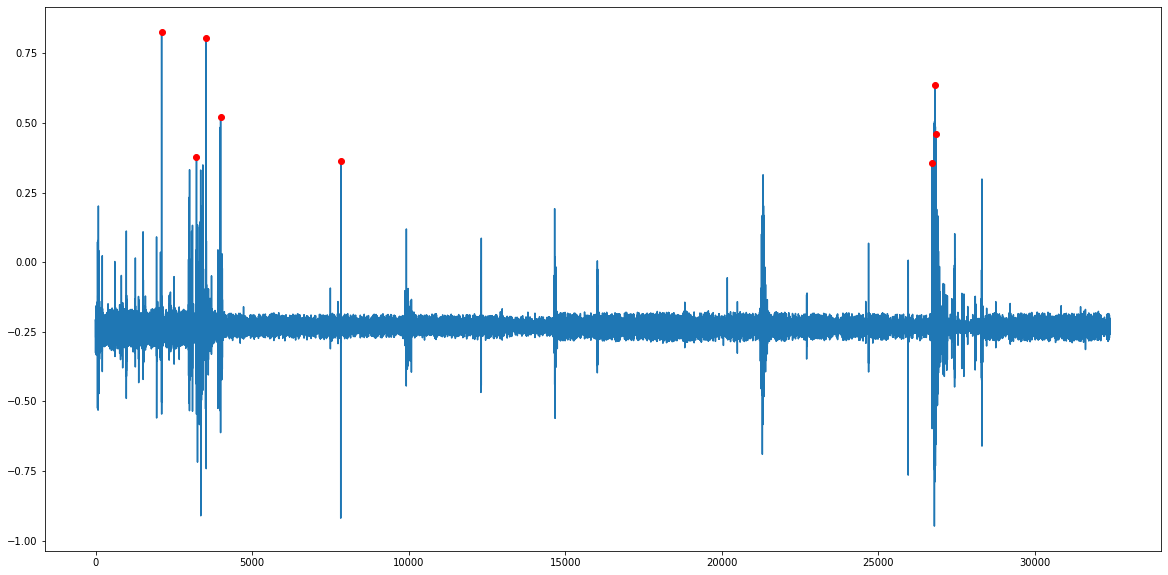

In [7]:
#on the transformed dataframe, we will find the rPeaks with a threshold of 0.35mV and we will plot the rPeaks
r_peaks = signal.find_peaks(data_transformed['ECG'], height=0.35, distance=50)
#make plot large
plt.figure(figsize=(20,10))
#we want to plot the indices as red dots on top of the signal
plt.plot(data_transformed['seconds'], data_transformed['ECG'])
plt.plot(data_transformed['seconds'][r_peaks[0]],data_transformed['ECG'][r_peaks[0]],'ro')

#find rr intervals
rr_intervals = pd.DataFrame(columns=['RR_intervals','timestamps'])
#we will use the rPeaks to find the RR intervals
rr_intervals['RR_intervals'] = np.diff(r_peaks[0])
#we will use the rPeaks to find the RR intervals
rr_intervals['timestamps'] = r_peaks[0][:-1]
#format timestamps to be in seconds (given that we are in 2hz)
rr_intervals['timestamps'] = rr_intervals['timestamps']/2
#print the first 5 rows of the dataframe
print(rr_intervals.tail())

#### For every 30 seconds on the new signal we want to calculate the total_power and the relative VLF,LF,HF,LF_HF_ratio. 
#### The frequencies for the given areas are VLF(0.003-0.04Hz), LF(0.04-0.15Hz), HF(0.15-0.4Hz), LF_HF_ratio(LF/HF).
#### We will create a periodogram using the welch function.

In [9]:
#we want to create a periodogram for data_transformed using welch's method
periodogram = signal.welch(data_transformed['ECG'], fs=2, nperseg=4096)
#since we are in 2hz we will convert the periodogram[0] and [1] from 2049 to 1024
print(len(periodogram[0]))
print(len(data_transformed['ECG']))

2049
64798


d:\Users\georg\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\signal\_spectral_py.py:1961: UserWarning: nperseg = 4096 is greater than input length  = 2160, using nperseg = 2160
  warnings.warn('nperseg = {0:d} is greater than input length '
C:\Users\georg\AppData\Local\Temp\ipykernel_13068\1403295827.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  status['status'][i] = 'HF'
C:\Users\georg\AppData\Local\Temp\ipykernel_13068\1403295827.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  status['status'][i] = 'VLF'
C:\Users\georg\AppData\Local\Temp\ipykernel_13068\1403295827.py:22: SettingWithCopyWa

VLF: 40
LF: 118
HF: 922
(1080, 2)
